In [11]:
import pandas as pd
from io import StringIO

## Pandas时间数据

使用`to_datetime`可以把字符串转为时间戳。Pandas一般能自动探测字符串中的时间格式。



In [2]:
pd.to_datetime('2021-08-01 20:00:00')

Timestamp('2021-08-01 20:00:00')

In [3]:
pd.to_datetime('08:00:00 PM')

Timestamp('2021-08-16 20:00:00')

也可以指定时间格式，加强检查，或消除歧义

In [9]:
pd.to_datetime('08:00:00 PM', format='%I:%M:%S %p')

Timestamp('1900-01-01 20:00:00')

如果时间数据分布在多列，最直接的方法是拼接后再解析

In [27]:
table_str = StringIO(
    '''
Date        Time      AM/PM
2021-01-01  08:00:00  PM
2021-08-01  08:00:00  PM
2021-08-02  12:00:00  PM
    '''
)
table = pd.read_table(
    table_str, sep='\s+'
)
table

,Date,Time,AM/PM
0,2021-01-01,08:00:00,PM
1,2021-08-01,08:00:00,PM
2,2021-08-02,12:00:00,PM


In [28]:
timedata = pd.to_datetime(table.Date + " " + table.Time + " " + table['AM/PM'])
timedata

0   2021-01-01 20:00:00
1   2021-08-01 20:00:00
2   2021-08-02 12:00:00
dtype: datetime64[ns]

时间序列的`dt`接口，类似字符串序列的`str`接口，可以提供时间数据的矢量化操作。如时区设置、转换等。

In [29]:
timedata.dt.tz_localize('Asia/Shanghai')

0   2021-01-01 20:00:00+08:00
1   2021-08-01 20:00:00+08:00
2   2021-08-02 12:00:00+08:00
dtype: datetime64[ns, Asia/Shanghai]

In [30]:
timedata.dt.tz_localize('Asia/Shanghai').dt.tz_convert('US/Pacific')

0   2021-01-01 04:00:00-08:00
1   2021-08-01 05:00:00-07:00
2   2021-08-01 21:00:00-07:00
dtype: datetime64[ns, US/Pacific]

也可以取出时间戳的各个部分

In [31]:
timedata.dt.time

0    20:00:00
1    20:00:00
2    12:00:00
dtype: object

In [32]:
timedata.dt.date

0    2021-01-01
1    2021-08-01
2    2021-08-02
dtype: object

In [35]:
timedata.dt.month_name()

0    January
1     August
2     August
dtype: object

In [36]:
timedata.dt.day_name()

0    Friday
1    Sunday
2    Monday
dtype: object

In [37]:
timedata.dt.dayofweek

0    4
1    6
2    0
dtype: int64

## 数据拼接

In [56]:
part1_str = StringIO(
    '''
Time            CPU     %user     %nice   %system   %iowait    %steal     %idle
02:06:14AM     all      0.20      0.00      0.20      0.00      0.00     99.60
02:06:19AM     all      0.00      0.00      0.00      0.00      0.00    100.00
    '''
)

part2_str = StringIO(
    '''
Time            CPU     %user     %nice   %system   %iowait    %steal     %idle
02:37:41AM     all     89.16      0.00     10.84      0.00      0.00      0.00
02:37:46AM     all     89.42      0.00     10.58      0.00      0.00      0.00
    '''
)

part3_str = StringIO(
    '''
Time            IFACE   rxpck/s   txpck/s    rxkB/s    txkB/s   rxcmp/s   txcmp/s  rxmcst/s   %ifutil
02:06:14AM     ens33      0.20      0.00      0.02      0.00      0.00      0.00      0.00      0.00
02:06:19AM     ens33      0.20      0.00      0.02      0.00      0.00      0.00      0.00      0.00
02:06:24AM     ens33      0.40      0.00      0.04      0.00      0.00      0.00      0.00      0.00
    '''
)

part1 = pd.read_table(part1_str, sep='\s+', index_col=0)
part2 = pd.read_table(part2_str, sep='\s+', index_col=0)
part3 = pd.read_table(part3_str, sep='\s+', index_col=0)
part1, part2, part3

(            CPU  %user  %nice  %system  %iowait  %steal  %idle
 Time                                                          
 02:06:14AM  all    0.2    0.0      0.2      0.0     0.0   99.6
 02:06:19AM  all    0.0    0.0      0.0      0.0     0.0  100.0,
             CPU  %user  %nice  %system  %iowait  %steal  %idle
 Time                                                          
 02:37:41AM  all  89.16    0.0    10.84      0.0     0.0    0.0
 02:37:46AM  all  89.42    0.0    10.58      0.0     0.0    0.0,
             IFACE  rxpck/s  txpck/s  ...  txcmp/s  rxmcst/s  %ifutil
 Time                                 ...                            
 02:06:14AM  ens33      0.2      0.0  ...      0.0       0.0      0.0
 02:06:19AM  ens33      0.2      0.0  ...      0.0       0.0      0.0
 02:06:24AM  ens33      0.4      0.0  ...      0.0       0.0      0.0
 
 [3 rows x 9 columns])

使用`pd.concat`可以拼接数据框或序列。默认为纵向拼接（行变多）。

In [57]:
pd.concat([part1, part2])

,CPU,%user,%nice,%system,%iowait,%steal,%idle
Time,,,,,,,
02:06:14AM,all,0.20,0.0,0.20,0.0,0.0,99.6
02:06:19AM,all,0.00,0.0,0.00,0.0,0.0,100.0
02:37:41AM,all,89.16,0.0,10.84,0.0,0.0,0.0
02:37:46AM,all,89.42,0.0,10.58,0.0,0.0,0.0


也可以设置`axis=columns`为横向拼接（列变多）

In [58]:
pd.concat([part1, part3], axis='columns')

,CPU,%user,%nice,%system,%iowait,%steal,%idle,IFACE,rxpck/s,txpck/s,rxkB/s,txkB/s,rxcmp/s,txcmp/s,rxmcst/s,%ifutil
02:06:14AM,all,0.2,0.0,0.2,0.0,0.0,99.6,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0
02:06:19AM,all,0.0,0.0,0.0,0.0,0.0,100.0,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0
02:06:24AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ens33,0.4,0.0,0.04,0.0,0.0,0.0,0.0,0.0


注意上面数据中出现了NaN，即拼接的时候，Pandas会考虑对齐Index（横向拼接）或Column（纵向拼接）。差异很大的表格，或者拼接方向错误，会出现大量NaN的结果，以及重复的Index、Column。此时需要检查：

* axis是否指定正确
* 数据是否正确

如果都正确，可以考虑进行缺失处理，或选用下一个方法。

In [59]:
pd.concat([part1, part2], axis='columns')

,CPU,%user,%nice,%system,%iowait,%steal,%idle,CPU,%user,%nice,%system,%iowait,%steal,%idle
02:06:14AM,all,0.2,0.0,0.2,0.0,0.0,99.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02:06:19AM,all,0.0,0.0,0.0,0.0,0.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02:37:41AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,all,89.16,0.0,10.84,0.0,0.0,0.0
02:37:46AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,all,89.42,0.0,10.58,0.0,0.0,0.0


In [60]:
pd.concat([part1, part3])

,CPU,%user,%nice,%system,%iowait,%steal,%idle,IFACE,rxpck/s,txpck/s,rxkB/s,txkB/s,rxcmp/s,txcmp/s,rxmcst/s,%ifutil
Time,,,,,,,,,,,,,,,,
02:06:14AM,all,0.2,0.0,0.2,0.0,0.0,99.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02:06:19AM,all,0.0,0.0,0.0,0.0,0.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02:06:14AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0
02:06:19AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0
02:06:24AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ens33,0.4,0.0,0.04,0.0,0.0,0.0,0.0,0.0


`pd.merge`提供类似数据库`join`的横向拼接操作。默认为内连接（只保留两个部分共有的数据）。

In [61]:
pd.merge(part1, part3, left_index=True, right_index=True)

,CPU,%user,%nice,%system,%iowait,%steal,%idle,IFACE,rxpck/s,txpck/s,rxkB/s,txkB/s,rxcmp/s,txcmp/s,rxmcst/s,%ifutil
Time,,,,,,,,,,,,,,,,
02:06:14AM,all,0.2,0.0,0.2,0.0,0.0,99.6,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0
02:06:19AM,all,0.0,0.0,0.0,0.0,0.0,100.0,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [62]:
part1.merge(part3, left_index=True, right_index=True)

,CPU,%user,%nice,%system,%iowait,%steal,%idle,IFACE,rxpck/s,txpck/s,rxkB/s,txkB/s,rxcmp/s,txcmp/s,rxmcst/s,%ifutil
Time,,,,,,,,,,,,,,,,
02:06:14AM,all,0.2,0.0,0.2,0.0,0.0,99.6,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0
02:06:19AM,all,0.0,0.0,0.0,0.0,0.0,100.0,ens33,0.2,0.0,0.02,0.0,0.0,0.0,0.0,0.0


## 时间数据统计

In [72]:
cpu = pd.read_table(
    "https://raw.githubusercontent.com/genzj/data-analysis-course/main/data/ch-04/sysstat-20210815-023757-cpu.txt",
    sep='\s+',
    skiprows=2,
)
cpu = cpu.set_index(pd.to_datetime(cpu.iloc[:, 0] + cpu.iloc[:, 1])).iloc[:, 3:]
print(cpu.shape)
cpu

(992, 6)


,%user,%nice,%system,%iowait,%steal,%idle
2021-08-16 02:38:02,86.97,0.0,12.83,0.2,0.0,0.00
2021-08-16 02:38:07,88.00,0.0,12.00,0.0,0.0,0.00
2021-08-16 02:38:12,86.80,0.0,13.20,0.0,0.0,0.00
2021-08-16 02:38:17,86.60,0.0,13.40,0.0,0.0,0.00
2021-08-16 02:38:22,86.00,0.0,14.00,0.0,0.0,0.00
...,...,...,...,...,...,...
2021-08-16 04:00:20,0.00,0.0,0.40,0.0,0.0,99.60
2021-08-16 04:00:25,0.00,0.0,0.61,0.0,0.0,99.39
2021-08-16 04:00:30,0.20,0.0,0.20,0.0,0.0,99.59
2021-08-16 04:00:35,0.00,0.0,0.61,0.0,0.0,99.39


### 重采样

重采样可以改变数据的频率。Pandas重采样本质上是一种特殊的GroupBy，对某一列（默认为对index）以指定的时间间隔来分组。

间隔大于原数据间隔，为降采样（数据变少）；间隔小于原数据间隔，为升采样（数据变多）。降采样需要指定统计方法，即如何把多个数据变成一个数据，如取平均、取最大值等；升采样需要指定插值方法，即多出来的数据应该填什么值。

In [83]:
cpu.resample('1min').mean()

,%user,%nice,%system,%iowait,%steal,%idle
2021-08-16 02:38:00,59.190833,0.0,8.937500,0.016667,0.0,31.855000
2021-08-16 02:39:00,0.050000,0.0,0.133333,0.000000,0.0,99.816667
2021-08-16 02:40:00,0.083333,0.0,0.133333,0.000000,0.0,99.782500
2021-08-16 02:41:00,0.066667,0.0,0.116667,0.000000,0.0,99.815833
2021-08-16 02:42:00,0.100000,0.0,0.116667,0.000000,0.0,99.782500
...,...,...,...,...,...,...
2021-08-16 03:56:00,0.109091,0.0,0.218182,0.000000,0.0,99.672727
2021-08-16 03:57:00,0.050000,0.0,0.116667,0.000000,0.0,99.833333
2021-08-16 03:58:00,0.050000,0.0,0.133333,0.000000,0.0,99.816667
2021-08-16 03:59:00,0.101667,0.0,2.488333,0.000000,0.0,97.410000


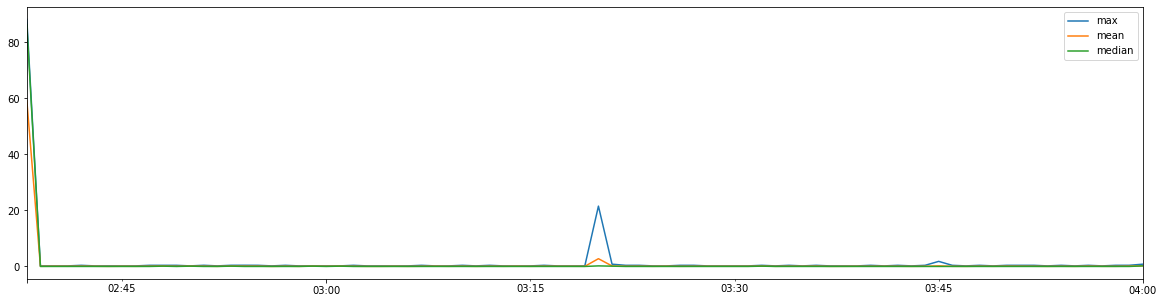

In [91]:
cpu.resample('1min')['%user'].agg(['max', 'mean', 'median']).plot(figsize=(20, 5))

### 滚动（滑动）窗口

`rolling`是另一种特殊的分组GroupBy。其以一个定长的滑动窗口把数据分到不同组。特点是每个数据可能会存在与多个组。

股票K线图中5日均线、10日均线等就是典型的滑动窗口平均统计。

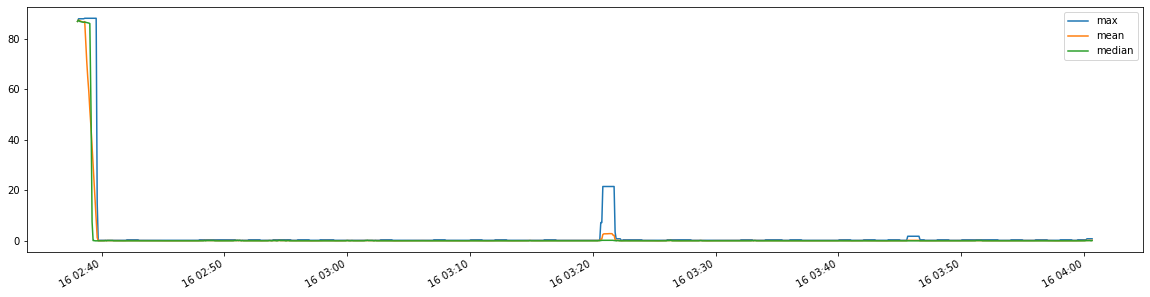

In [97]:
cpu.rolling('1min')['%user'].agg(['max', 'mean', 'median']).plot(figsize=(20, 5))